In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn import preprocessing
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline

import mlflow

import logging
import pickle

import sys
  

# setting path
sys.path.append('../scripts')
from preprocessing_functions import weekends, time_of_month, label_holidays


Bad key "text.kerning_factor" on line 4 in
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Load Dataset

In [2]:
logging.info('Load Training Set')

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
df_train = pd.read_csv('../data/train_clean.csv', na_values=['?', None, 'undefined'])
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,1,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,1,31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,1,31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,1,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,1,31,7,2015


In [4]:
logging.info('Load Test Set')

In [5]:
df_test = pd.read_csv('../data/test_clean.csv', na_values=['?', None, 'undefined'])
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year
0,1,1,4,2015-09-17,1.0,1,0,0,0,17,9,2015
1,2,3,4,2015-09-17,1.0,1,0,0,0,17,9,2015
2,3,7,4,2015-09-17,1.0,1,0,0,0,17,9,2015
3,4,8,4,2015-09-17,1.0,1,0,0,0,17,9,2015
4,5,9,4,2015-09-17,1.0,1,0,0,0,17,9,2015


In [6]:
logging.info('Load Store Info')

In [7]:
df_store = pd.read_csv('../data/store.csv', na_values=['?', None, 'undefined'])
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Add some more features to dataset

In [8]:
df_train['Weekend'] = df_train['DayOfWeek'].apply(weekends)
df_test['Weekend'] = df_test['DayOfWeek'].apply(weekends)

df_train['TimeOfMonth'] = df_train['Day'].apply(time_of_month)
df_test['TimeOfMonth'] = df_test['Day'].apply(time_of_month)

df_train['Holiday'] = df_train['StateHoliday'].apply(label_holidays)
df_test['Holiday'] = df_test['StateHoliday'].apply(label_holidays)

df_train['Date'] = pd.DatetimeIndex(df_train['Date'])


In [9]:
df_weekends = df_train[['Store', 'DayOfWeek','Open', 'Sales','Customers']]
df_weekends = df_weekends[df_weekends['Open'] == 1]
weekend_stores = df_weekends[['Store', 'DayOfWeek']].groupby('Store').nunique()
weekend_stores = weekend_stores[weekend_stores['DayOfWeek'] == 7].reset_index()
len(weekend_stores)

33

In [10]:
df_weekends = df_weekends[df_weekends['Store'].isin(set(weekend_stores['Store']))]
weekendstores = set(df_weekends['Store'])

def isallweekstore(x):
    if x in weekendstores:
        return 1
    return 0

df_train['7DayStore'] = df_train['Store'].apply(isallweekstore)

In [11]:

df_store['CompetitionDistance'] = df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].max())
df_store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:
df_train = df_train.merge(df_store, on='Store', how='left')
df_test = df_test.merge(df_store, on='Store', how='left')

In [13]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year,Weekend,TimeOfMonth,7DayStore,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,1,31,7,2015,0,2,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,1,31,7,2015,0,2,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,1,31,7,2015,0,2,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,1,31,7,2015,0,2,0,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,1,31,7,2015,0,2,0,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
le = preprocessing.LabelEncoder()
df_train['StoreType'] = le.fit_transform(df_train['StoreType'])
df_train['Assortment'] = le.fit_transform(df_train['Assortment'])

df_test['StoreType'] = le.fit_transform(df_train['StoreType'])
df_test['Assortment'] = le.fit_transform(df_train['Assortment'])

ValueError: Length of values (1017209) does not match length of index (41077)

In [15]:
# def days_to_holiday(x, holidays):
#     upcoming_holidays = holidays[holidays >= x]
#     passed_holidays = holidays[holidays <= x]
    

# def days_to_holiday(x, holidays):
#     upcoming_holidays = holidays[holidays >= x]
#     passed_holidays = holidays[holidays <= x]

In [16]:
# holidays = pd.Series(list(set(df_train[df_train['StateHoliday'] != '0']['Date'])))

In [33]:
x = df_train[['Store','DayOfWeek', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day', 'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType','Assortment','CompetitionDistance', 'Promo2']]
y_scaler = StandardScaler()
y = y_scaler.fit_transform(df_train[['Sales']].values)
train_features = x.columns
x = x.values

### Linear Regression Pipeline with 5 fold cross validation

In [34]:

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='linear_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
        reg_pipe.fit(X_train, y_train)
        score = reg_pipe.score(X_test, y_test)
        print("score:", reg_pipe.score(X_train, y_train))
        #log model params
        mlflow.log_param("lin_reg_score", score)

        # log model
        mlflow.sklearn.log_model(reg_pipe, "lin_regression_models")
        mlflow.end_run()

score: 0.5543714074104493
score: 0.5614899865809281
score: 0.5539143713396744
score: 0.5668176342536282
score: 0.5612671864706053


### Random Forest Regressor Pipeline with 5 fold cross validation

In [35]:
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='random_forest_reg_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        forest_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators = 10, max_depth = 20))])
        forest_pipe.fit(X_train, y_train)
        score = forest_pipe.score(X_test, y_test)
        print("score:", score)
        #log model params
        mlflow.log_param("rand_forest_reg_score", score)

        # log model
        mlflow.sklearn.log_model(forest_pipe, "random_forest_regression_models")
        mlflow.end_run()

score: 0.9047842683982257
score: 0.8864430987249003
score: 0.8997000653428963
score: 0.8781384408383267
score: 0.89522914427523


### Save Model

In [72]:
filename = '../models/forest-'+datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+f'-{now.microsecond}.sav'
pickle.dump(forest_pipe, open(filename, 'wb'))

In [71]:
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=10))])

### Feature importance

#### Linear Regression Model

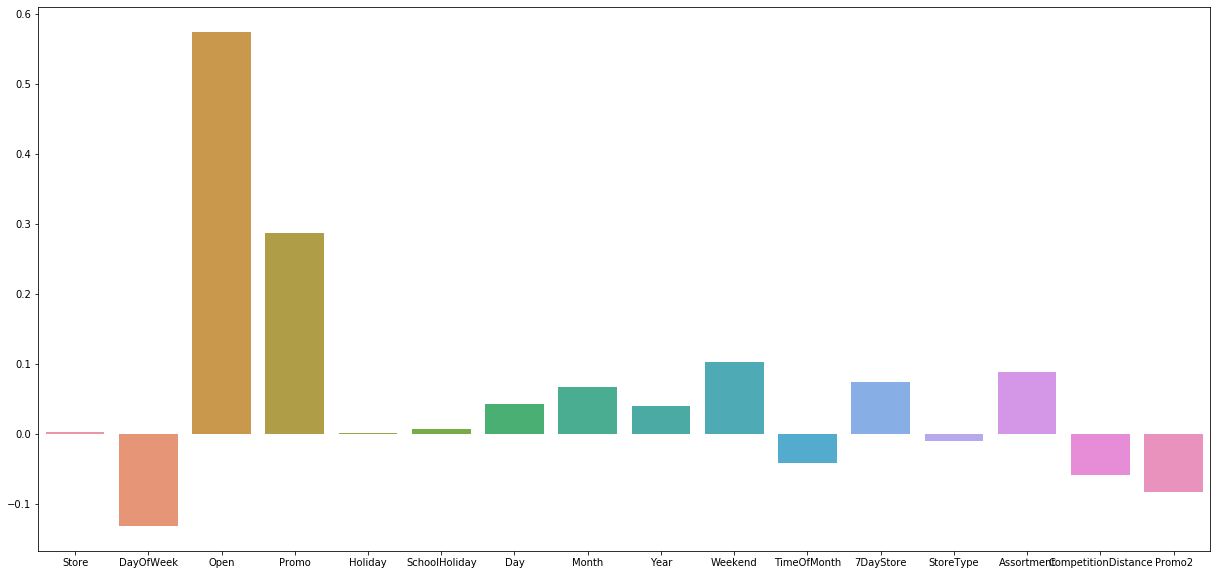

In [37]:
plt.figure(figsize=(21,10))
sns.barplot(x = train_features, y = reg_pipe[1].coef_[0])

<h5> As Day of week, time of month, distance from competition, and Promo2 increase, the sales value decreases
The most important features are whether the store was open and whether the store ran a promo. </h5>

#### Random Forest Regression Model Feature Importance

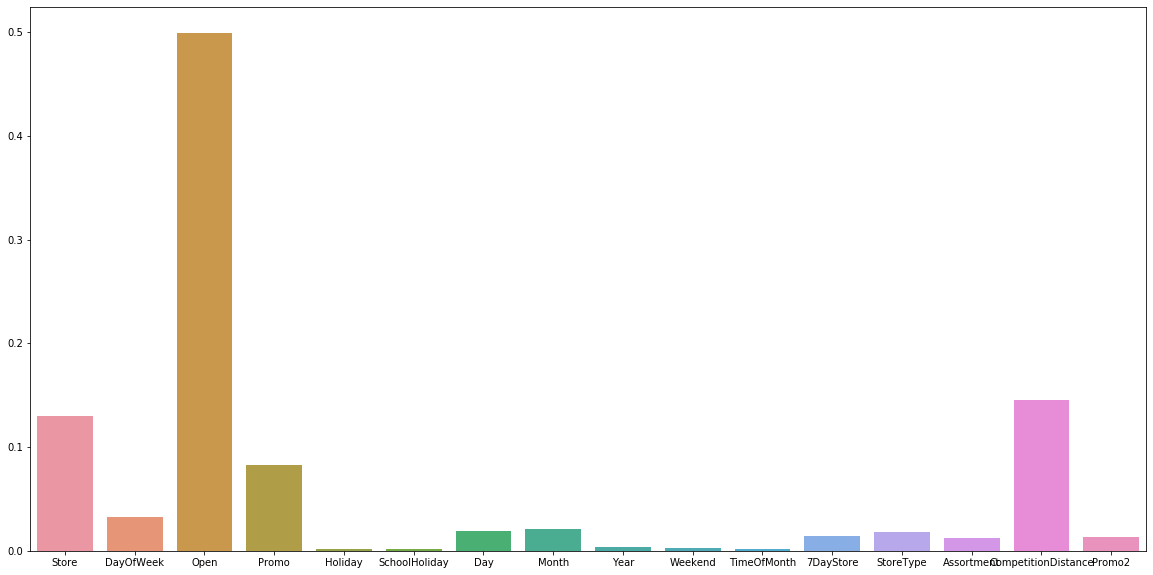

In [32]:
plt.figure(figsize=(20,10))
sns.barplot(x = train_features, y = forest_pipe[1].feature_importances_)

<h5> Here, the most important features are whether it's open, the store id, the competition distance, and whether a promo was done on that day or not <h5>

In [45]:
from datetime import datetime
f'{datetime.now().day}-{datetime.now().month}-{datetime.now().year}-{datetime.now().hour}-{datetime.now().minute}-{datetime.now().second}'

'30-7-2021-2-24-27'

In [50]:
now.strftime("%d-%m-%Y-%H-%M-%S")+f'{now.microsecond}'

'30-07-2021-02-19-46319680'